In this notebook, I will answer my first question : How listing attributes affect good ratings.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
listing_df = pd.read_csv('data/listings.csv')
calendar_df = pd.read_csv('data/calendar.csv')
review_df = pd.read_csv('data/reviews.csv')

In [3]:
listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

22.6% of the dataset does not have review_scores_rating as shown below

In [4]:
print('Percentage dataset with missing rating : {}%'.format(100*len(listing_df[listing_df.review_scores_rating.isna()])/len(listing_df)))

Percentage dataset with missing rating : 22.677824267782427%


In [5]:
print('Percentage dataset without price : {}%'.format(100*len(listing_df[listing_df.price.isna()])/len(listing_df)))

Percentage dataset without price : 0.0%


In [6]:
new_listing_df = listing_df.dropna(subset=['review_scores_rating'])

The ratings is left skewed. So most of the listing have high ratings.

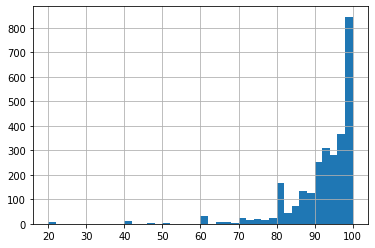

In [7]:
new_listing_df.review_scores_rating.hist(bins=40)

We can see number of listings per neighbourhood from below chart

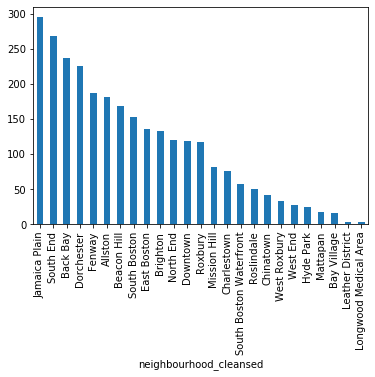

In [8]:
new_listing_df.groupby(['neighbourhood_cleansed']).id.count().sort_values(ascending=False).plot(kind='bar')

Let's see what is the ratings on the neighbourhood with high amount of listings. I put 100 as a filter of high listings. 

In [9]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_rating.median().sort_values(ascending=False)

neighbourhood_cleansed
South Boston     96.0
Jamaica Plain    96.0
South End        95.0
North End        95.0
Beacon Hill      95.0
Downtown         94.0
Brighton         94.0
Allston          94.0
Fenway           93.0
Dorchester       93.0
Back Bay         93.0
East Boston      92.0
Roxbury          91.0
Name: review_scores_rating, dtype: float64

All the neighbourhood is having >90 ratings. Let's see what about other scores

In [10]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_communication.median().sort_values(ascending=False)

neighbourhood_cleansed
South End        10.0
South Boston     10.0
Roxbury          10.0
North End        10.0
Jamaica Plain    10.0
Fenway           10.0
East Boston      10.0
Downtown         10.0
Dorchester       10.0
Brighton         10.0
Beacon Hill      10.0
Back Bay         10.0
Allston          10.0
Name: review_scores_communication, dtype: float64

In [11]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_location.median().sort_values(ascending=False)

neighbourhood_cleansed
South End        10.0
North End        10.0
Jamaica Plain    10.0
Fenway           10.0
Downtown         10.0
Beacon Hill      10.0
Back Bay         10.0
South Boston      9.0
East Boston       9.0
Dorchester        9.0
Brighton          9.0
Allston           9.0
Roxbury           8.0
Name: review_scores_location, dtype: float64

In [12]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_value.median().sort_values(ascending=False)

neighbourhood_cleansed
South Boston     10.0
Jamaica Plain    10.0
South End         9.0
Roxbury           9.0
North End         9.0
Fenway            9.0
East Boston       9.0
Downtown          9.0
Dorchester        9.0
Brighton          9.0
Beacon Hill       9.0
Back Bay          9.0
Allston           9.0
Name: review_scores_value, dtype: float64

In [13]:
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 100).groupby(['neighbourhood_cleansed']).review_scores_checkin.median().sort_values(ascending=False)

neighbourhood_cleansed
South End        10.0
South Boston     10.0
Roxbury          10.0
North End        10.0
Jamaica Plain    10.0
Fenway           10.0
East Boston      10.0
Downtown         10.0
Dorchester       10.0
Brighton         10.0
Beacon Hill      10.0
Back Bay         10.0
Allston          10.0
Name: review_scores_checkin, dtype: float64

The other scores does not gives much information.

Next, we can check how the listing features affect the ratings. First we can determine the feature.

In [14]:
features = new_listing_df[['host_listings_count', 'host_total_listings_count', 'accommodates', 
                     'bathrooms', 'bedrooms', 'beds','guests_included','review_scores_rating','price']]

Process amenities data by splitting it into separate features

In [15]:
new_listing_df['amenities'].head(10)

1     {TV,Internet,"Wireless Internet","Air Conditio...
2     {TV,"Cable TV","Wireless Internet","Air Condit...
3     {TV,Internet,"Wireless Internet","Air Conditio...
4     {Internet,"Wireless Internet","Air Conditionin...
5     {"Cable TV","Wireless Internet","Air Condition...
6     {TV,Internet,"Wireless Internet",Kitchen,"Free...
7     {TV,Internet,"Wireless Internet","Air Conditio...
8     {"Wireless Internet","Pets live on this proper...
9     {TV,"Cable TV",Internet,"Wireless Internet","A...
10    {TV,"Wireless Internet","Air Conditioning",Kit...
Name: amenities, dtype: object

In [16]:
amenities = np.unique(np.concatenate([amns.replace('"','').replace('{','').replace('}','').split(',') for amns in new_listing_df['amenities']],axis=None))[1:]
amenity_arr = np.array([new_listing_df['amenities'].map(lambda amns: 1 if amn in amns else 0) for amn in amenities])
features = pd.concat([features, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

we can use the feature with true and false values as well.

In [17]:
for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    features[tf_feature] = new_listing_df[tf_feature].map(lambda s: 0 if s == "f" else 1)

combining categorical feature

In [18]:
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(new_listing_df[categorical_feature])], axis=1)

combining price

In [19]:
features['price'] =  [np.nan if str(x) == 'nan' else str(x).replace('$','').replace(',','') for x in features.price]

Looking at the numbers of rows, we can drop the rows instead of the columns

In [21]:
features = features.dropna(axis=0)

Let's see how the feature correlate with rating.

In [56]:
features.corr().review_scores_rating.sort_values(ascending=False)

review_scores_rating       1.000000
host_is_superhost          0.233151
Jamaica Plain              0.088224
host_identity_verified     0.077706
Condominium                0.067513
                             ...   
requires_license                NaN
Allston                         NaN
South Boston                    NaN
South Boston Waterfront         NaN
Entire Floor                    NaN
Name: review_scores_rating, Length: 106, dtype: float64

From the chart we can see host_is_superhost has the highest correlation with rating and the host_identity_verfied is second place.

This is superhost definition from AirBNB :

**What is a Superhost?
Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests.**

**Once a host reaches Superhost status, a badge superhost badge will automatically appear on their listing and profile to help you identify them.**


**We check Superhosts’ activity four times a year, to ensure that the program highlights the people who are most dedicated to providing outstanding hospitality.**

So in summary, superhosts are high quality hosts, so logically this should be one of the best predictor of the ratings.


Next we can do the prediction

In [23]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [24]:
clf_lr = LinearRegression()
clf_las = Lasso()
clf_rf = RandomForestRegressor()
y = features['review_scores_rating']
x = features.drop('review_scores_rating', axis='columns')
clf_lr.fit(x, y)
clf_las.fit(x, y)
clf_rf.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [25]:
y_pred_lr = clf_lr.predict(x)
y_pred_las = clf_las.predict(x)
y_pred_rf = clf_rf.predict(x)

In [26]:
print('linear regression r2 score : ',r2_score(y, y_pred_lr))
print('lasso r2 score : ',r2_score(y, y_pred_las))
print('random forrest r2 score : ',r2_score(y, y_pred_rf))

linear regression r2 score :  0.1565322736886382
lasso r2 score :  0.045536649059475076
random forrest r2 score :  0.8820028194260512


In [27]:
r2_score(y, y_pred_lr)

0.1565322736886382

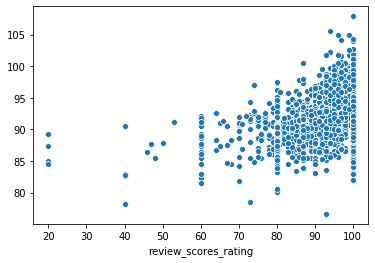

In [28]:
sns.scatterplot(y,y_pred_lr)

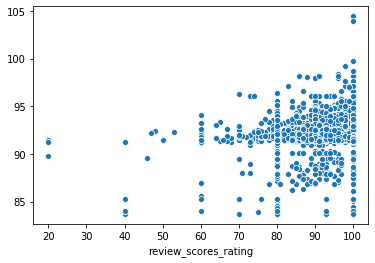

In [29]:
sns.scatterplot(y,y_pred_las)

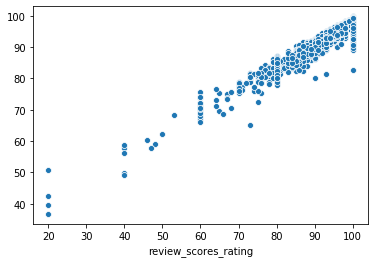

In [30]:
sns.scatterplot(y,y_pred_rf)

From the prediction result, we can see that random forrest has the best result. Let's see about the feature importance.

In [53]:
importances=clf_rf.feature_importances_

In [54]:
df_importances = pd.concat([pd.DataFrame(x.columns),pd.DataFrame(importances,columns=['importances'])], axis=1)

In [55]:
df_importances.sort_values('importances',ascending=False)

,0,importances
7,price,0.165161
53,host_is_superhost,0.052049
0,host_listings_count,0.050541
1,host_total_listings_count,0.044839
2,accommodates,0.030653
...,...,...
61,Allston,0.000000
91,Entire Floor,0.000000
82,South Boston Waterfront,0.000000
81,South Boston,0.000000


Price has the highest features importance value with host_is_superhost the second. Logically this two variables is very important to determine the ratings. 

If the listings has good amenities and combine with low price, logically this will make the ratings quite good.